# Generate seurat object


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from scipy import sparse



sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

In [2]:
epithelials = ['preCiliated',
'SOX9_basalis',
'SOX9_functionalis_I',
'SOX9_functionalis_II',
'SOX9_luminal',
'SOX9_basalis',
'Ciliated',
'preGlandular',
'preLuminal',
'Glandular',
'Luminal',
'Glandular_secretory',
'Glandular_secretory_FGF7']

mesenchymal = ['ePV_2',
'eStromal',
'eStromal_MMPs',
'ePV_1a',
'ePV_1b',
'Fibroblast_basalis',
'dStromal_early',
'dStromal_mid',
'dStromal_late'
]

immune = ['uNK1', 'uNK3', 'eM1', 'eM2']

In [3]:
celltypes_of_interest = mesenchymal # sum([immune, mesenchymal, epithelials], [])

## Load raw counts for sample of interest

In [4]:
adata = sc.read('/nfs/team292/lg18/endometriosis/integrated_objects/nuclei_integrated.h5ad')
adata.X.shape

(372867, 33578)

In [5]:
annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/nuclei_endometrium.csv',index_col=0)
annot_df.head()
annot_all = annot_df['Nuc_celltype'].to_dict()
annot = dict(annot_all)
adata.obs['Nuc_celltype'] = adata.obs_names.map(annot)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/nuclei_epithelials_endometrium.csv',index_col=0)
annot_df.at[annot_df['Nuc_epi_celltype'] == 'Hormones', 'Nuc_epi_celltype'] = 'eHormones'
annot_df.at[annot_df['Nuc_epi_celltype'] == 'Hormones_secretory', 'Nuc_epi_celltype'] = 'eHormones'
annot_df.head()
annot1 = annot_df['Nuc_epi_celltype'].to_dict()
annot.update(annot1)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/nuclei_endometrium_mesenchymal.csv',index_col=0)
annot_df.at[annot_df['Nuc_mesen_celltype'] == 'Hormones', 'Nuc_mesen_celltype'] = 'sHormones'
annot_df.at[annot_df['Nuc_mesen_celltype'] == 'Fibroblats_basalis', 'Nuc_mesen_celltype'] = 'Fibroblast_basalis'
annot_df.head()
annot2 = annot_df['Nuc_mesen_celltype'].to_dict()
annot.update(annot2)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/nuclei_endometrium_endothelial.csv',index_col=0)
annot_df.head()
annot2 = annot_df['Nuc_endo_celltype'].to_dict()
annot.update(annot2)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/nuclei_endometrium_PV.csv',index_col=0)
annot_df.head()
annot2 = annot_df['Nuc_pv_celltype'].to_dict()
annot.update(annot2)


annot_df = pd.read_csv('/lustre/scratch126/cellgen/team292/sh50/data/nuclei_immune_labels.csv',index_col=0)
annot_df.head()
annot2 = annot_df['immune_subcluster_labels'].to_dict()
annot.update(annot2)


adata.obs['celltype'] = adata.obs_names.map(annot)
print(adata.obs['celltype'].value_counts())

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (24,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Doublet                  52349
eStromal                 46062
SOX9_functionalis_II     38538
eStromal_MMPs            21598
preGlandular             18101
Cycling                  16859
dStromal_early           16576
Glandular                15355
Glandular_secretory      14854
dStromal_late            14310
dStromal_mid             13676
eHormones                13459
LowQC                    13025
eStromal_cycling          9922
MUC5B                     9246
SOX9_luminal              6006
HOXA13                    5133
eM2                       4960
SOX9_basalis              4708
uNK1                      4659
preLuminal                3822
Venous                    3394
Luminal                   3146
Ciliated                  2606
eM1                       2358
Cycling_uNK1              2320
uNK2                      1974
CD4_T                     1871
cDC2                      1490
ePV_2                     1488
PV                        1270
CD8_T                     1033
uNK3    

### Subset to clusters of interest

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Nuc_celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


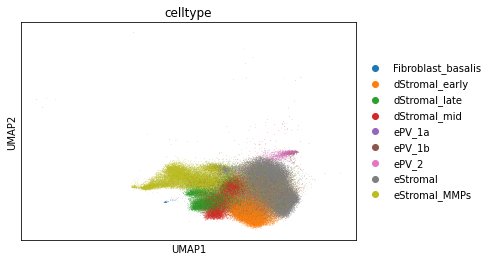

In [6]:
adata = adata[[ i in celltypes_of_interest for i in adata.obs['celltype'] ]]
sc.pl.umap(adata, color=['celltype'])

### Exclude cycling cells

In [7]:
adata = adata[[ i in ["G1"] for i in adata.obs.phase ]]

## Exclude patients under hormones

In [8]:
adata = adata[[ i not in ["Hormones", "PeriMenopause_Hormones", "Unknown"] for i in adata.obs['Binary Stage'] ]]
print(adata.obs['Binary Stage'].value_counts())

Proliferative    37597
Secretory        35439
Menstrual         6443
Name: Binary Stage, dtype: int64


### Define disease column

In [9]:
adata.obs['disease'] = 'Endo'
adata.obs.at[adata.obs['Group'] == 'Ctrl_whole_uterus', 'disease'] = 'Ctrl'
adata.obs.at[adata.obs['Group'] == 'Ctrl_Superficial', 'disease'] = 'Ctrl'
print(adata.obs['disease'].value_counts())

Trying to set attribute `.obs` of view, copying.


Endo    58607
Ctrl    20872
Name: disease, dtype: int64


# Move to Seurat

In [10]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [11]:
import anndata
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
# This is just to allow moving adata to R without errors
adata.X = adata.X.toarray()

idx = ['n_genes', 'sample',  'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 
       'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet']
for i in idx:
    del adata.obs[i]
    
adata.obs['celltype'] = adata.obs['celltype'].astype(str)

del adata.obsm['X_scVI']
del adata.obsm['X_umap']
del adata.obsp['connectivities']
del adata.obsp['distances']
del adata.uns

In [13]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 30595 79479 
metadata(0):
assays(1): X
rownames(30595): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(165): gene_ids.0 feature_types.0 ... variances_norm
  highly_variable_nbatches
colnames(79479): UA_Endo11596521_GAACACTCAGAGAAAG
  UA_Endo12449301_TCAGTGATCGTAGGGA ... UA_Endo11460963_GTAGGAGAGTGGATAT
  UA_Endo11460960_GAAGGACGTCCCTCAT
colData names(44): library StudyName ... celltype disease
reducedDimNames(0):
altExpNames(0):


In [14]:
%%R

library(Seurat)
seurat_andata = as.Seurat(adata, counts = "X", data = "X")
rm(adata)
Idents(seurat_andata) = seurat_andata$celltype

saveRDS(seurat_andata, "/nfs/team292/lg18/endometriosis/SeuratR_objects/nuclei_mesenchymal.rds")
rm(seurat_andata)
